In [1]:
from pyspark import SparkContext
from pyspark.sql.types import *
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lit
from functools import reduce
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud  #conda install -c conda-forge wordcloud
import pandas as pd
import re
import string

In [2]:
spark = SparkSession.builder.master('Sentiment_Analysis').appName('Amazon_Alexa_User_Review').getOrCreate()

In [3]:
schema = StructType([
    StructField("rating", IntegerType(), True),
    StructField("date", StringType(), True),
    StructField("variation", StringType(), True),
    StructField("verified_reviews", StringType(), True),
    StructField("feedback", IntegerType(), True)])

data = spark.read.format("org.apache.spark.csv").option("delimiter","\t").schema(schema).option("mode", "PERMISSIVE").option("inferSchema", "True").csv('file:////Users/mostafa/Downloads/amazon_alexa.tsv')

In [4]:
data.show(10)

+------+---------+--------------------+--------------------+--------+
|rating|     date|           variation|    verified_reviews|feedback|
+------+---------+--------------------+--------------------+--------+
|  null|     date|           variation|    verified_reviews|    null|
|     5|31-Jul-18|    Charcoal Fabric |       Love my Echo!|       1|
|     5|31-Jul-18|    Charcoal Fabric |           Loved it!|       1|
|     4|31-Jul-18|      Walnut Finish |Sometimes while p...|       1|
|     5|31-Jul-18|    Charcoal Fabric |I have had a lot ...|       1|
|     5|31-Jul-18|    Charcoal Fabric |               Music|       1|
|     5|31-Jul-18|Heather Gray Fabric |I received the ec...|       1|
|     3|31-Jul-18|   Sandstone Fabric |Without having a ...|       1|
|     5|31-Jul-18|    Charcoal Fabric |I think this is t...|       1|
|     5|30-Jul-18|Heather Gray Fabric |         looks great|       1|
+------+---------+--------------------+--------------------+--------+
only showing top 10 

In [5]:
reviews_rdd = data.select("verified_reviews").rdd.flatMap(lambda x: x)
reviews_rdd.collect()

['verified_reviews',
 'Love my Echo!',
 'Loved it!',
 'Sometimes while playing a game, you can answer a question correctly but Alexa says you got it wrong and answers the same as you.  I like being able to turn lights on and off while away from home.',
 'I have had a lot of fun with this thing. My 4 yr old learns about dinosaurs, i control the lights and play games like categories. Has nice sound when playing music as well.',
 'Music',
 'I received the echo as a gift. I needed another Bluetooth or something to play music easily accessible, and found this smart speaker. Can’t wait to see what else it can do.',
 'Without having a cellphone, I cannot use many of her features. I have an iPad but do not see that of any use.  It IS a great alarm.  If u r almost deaf, you can hear her alarm in the bedroom from out in the living room, so that is reason enough to keep her.It is fun to ask random questions to hear her response.  She does not seem to be very smartbon politics yet.',
 "I think thi

In [6]:
header = reviews_rdd.first()
data_rmv_col = reviews_rdd.filter(lambda row: row != header)

lowerCase_sentRDD = data_rmv_col.map(lambda x : x.lower())

In [7]:
lowerCase_sentRDD.collect()

['love my echo!',
 'loved it!',
 'sometimes while playing a game, you can answer a question correctly but alexa says you got it wrong and answers the same as you.  i like being able to turn lights on and off while away from home.',
 'i have had a lot of fun with this thing. my 4 yr old learns about dinosaurs, i control the lights and play games like categories. has nice sound when playing music as well.',
 'music',
 'i received the echo as a gift. i needed another bluetooth or something to play music easily accessible, and found this smart speaker. can’t wait to see what else it can do.',
 'without having a cellphone, i cannot use many of her features. i have an ipad but do not see that of any use.  it is a great alarm.  if u r almost deaf, you can hear her alarm in the bedroom from out in the living room, so that is reason enough to keep her.it is fun to ask random questions to hear her response.  she does not seem to be very smartbon politics yet.',
 "i think this is the 5th one i've

In [8]:
def sent_TokenizeFunct(x):
    return nltk.sent_tokenize(x)

sentenceTokenizeRDD = lowerCase_sentRDD.map(sent_TokenizeFunct)

sentenceTokenizeRDD.collect()

[['love my echo!'],
 ['loved it!'],
 ['sometimes while playing a game, you can answer a question correctly but alexa says you got it wrong and answers the same as you.',
  'i like being able to turn lights on and off while away from home.'],
 ['i have had a lot of fun with this thing.',
  'my 4 yr old learns about dinosaurs, i control the lights and play games like categories.',
  'has nice sound when playing music as well.'],
 ['music'],
 ['i received the echo as a gift.',
  'i needed another bluetooth or something to play music easily accessible, and found this smart speaker.',
  'can’t wait to see what else it can do.'],
 ['without having a cellphone, i cannot use many of her features.',
  'i have an ipad but do not see that of any use.',
  'it is a great alarm.',
  'if u r almost deaf, you can hear her alarm in the bedroom from out in the living room, so that is reason enough to keep her.it is fun to ask random questions to hear her response.',
  'she does not seem to be very smart

In [9]:
def word_TokenizeFunct(x):
    splittedwordTokenize = [word for line in x for word in line.split()]
    return splittedwordTokenize

wordTokenizeRDD = sentenceTokenizeRDD.map(word_TokenizeFunct)

wordTokenizeRDD.collect()

[['love', 'my', 'echo!'],
 ['loved', 'it!'],
 ['sometimes',
  'while',
  'playing',
  'a',
  'game,',
  'you',
  'can',
  'answer',
  'a',
  'question',
  'correctly',
  'but',
  'alexa',
  'says',
  'you',
  'got',
  'it',
  'wrong',
  'and',
  'answers',
  'the',
  'same',
  'as',
  'you.',
  'i',
  'like',
  'being',
  'able',
  'to',
  'turn',
  'lights',
  'on',
  'and',
  'off',
  'while',
  'away',
  'from',
  'home.'],
 ['i',
  'have',
  'had',
  'a',
  'lot',
  'of',
  'fun',
  'with',
  'this',
  'thing.',
  'my',
  '4',
  'yr',
  'old',
  'learns',
  'about',
  'dinosaurs,',
  'i',
  'control',
  'the',
  'lights',
  'and',
  'play',
  'games',
  'like',
  'categories.',
  'has',
  'nice',
  'sound',
  'when',
  'playing',
  'music',
  'as',
  'well.'],
 ['music'],
 ['i',
  'received',
  'the',
  'echo',
  'as',
  'a',
  'gift.',
  'i',
  'needed',
  'another',
  'bluetooth',
  'or',
  'something',
  'to',
  'play',
  'music',
  'easily',
  'accessible,',
  'and',
  'found',

In [10]:
def removeStopWordsFunct(x):
    from nltk.corpus import stopwords
    stop_words=set(stopwords.words('english'))
    filteredSentence = [w for w in x if not w in stop_words]
    return filteredSentence

stopwordRDD = wordTokenizeRDD.map(removeStopWordsFunct)

def removePunctuationsFunct(x):
    list_punct=list(string.punctuation)
    filtered = [''.join(c for c in s if c not in list_punct) for s in x] 
    filtered_space = [s for s in filtered if s] #remove empty space 
    return filtered

rmvPunctRDD = stopwordRDD.map(removePunctuationsFunct)

In [11]:
rmvPunctRDD.collect()

[['love', 'echo'],
 ['loved', 'it'],
 ['sometimes',
  'playing',
  'game',
  'answer',
  'question',
  'correctly',
  'alexa',
  'says',
  'got',
  'wrong',
  'answers',
  'you',
  'like',
  'able',
  'turn',
  'lights',
  'away',
  'home'],
 ['lot',
  'fun',
  'thing',
  '4',
  'yr',
  'old',
  'learns',
  'dinosaurs',
  'control',
  'lights',
  'play',
  'games',
  'like',
  'categories',
  'nice',
  'sound',
  'playing',
  'music',
  'well'],
 ['music'],
 ['received',
  'echo',
  'gift',
  'needed',
  'another',
  'bluetooth',
  'something',
  'play',
  'music',
  'easily',
  'accessible',
  'found',
  'smart',
  'speaker',
  'can’t',
  'wait',
  'see',
  'else',
  'do'],
 ['without',
  'cellphone',
  'cannot',
  'use',
  'many',
  'features',
  'ipad',
  'see',
  'use',
  'great',
  'alarm',
  'u',
  'r',
  'almost',
  'deaf',
  'hear',
  'alarm',
  'bedroom',
  'living',
  'room',
  'reason',
  'enough',
  'keep',
  'herit',
  'fun',
  'ask',
  'random',
  'questions',
  'hear',
 

In [15]:
from nltk.corpus import wordnet

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    try:
        treebank_tag = nltk.pos_tag([word])[0][1].upper()
        if treebank_tag.startswith('J'):
            return wordnet.ADJ
        elif treebank_tag.startswith('V'):
            return wordnet.VERB
        elif treebank_tag.startswith('N'):
            return wordnet.NOUN
        elif treebank_tag.startswith('R'):
            return wordnet.ADV
        else:
            return wordnet.NOUN
    except:
        return wordnet.NOUN
        

def lemmatizationFunct(x):
    lemmatizer = WordNetLemmatizer()
    finalLem = [lemmatizer.lemmatize(s,get_wordnet_pos(s) ) for s in x]
    return finalLem

lem_wordsRDD = rmvPunctRDD.map(lemmatizationFunct)
lem_wordsRDD.collect()

[['love', 'echo'],
 ['love', 'it'],
 ['sometimes',
  'play',
  'game',
  'answer',
  'question',
  'correctly',
  'alexa',
  'say',
  'get',
  'wrong',
  'answer',
  'you',
  'like',
  'able',
  'turn',
  'light',
  'away',
  'home'],
 ['lot',
  'fun',
  'thing',
  '4',
  'yr',
  'old',
  'learns',
  'dinosaur',
  'control',
  'light',
  'play',
  'game',
  'like',
  'category',
  'nice',
  'sound',
  'play',
  'music',
  'well'],
 ['music'],
 ['receive',
  'echo',
  'gift',
  'need',
  'another',
  'bluetooth',
  'something',
  'play',
  'music',
  'easily',
  'accessible',
  'found',
  'smart',
  'speaker',
  'can’t',
  'wait',
  'see',
  'else',
  'do'],
 ['without',
  'cellphone',
  'cannot',
  'use',
  'many',
  'feature',
  'ipad',
  'see',
  'use',
  'great',
  'alarm',
  'u',
  'r',
  'almost',
  'deaf',
  'hear',
  'alarm',
  'bedroom',
  'living',
  'room',
  'reason',
  'enough',
  'keep',
  'herit',
  'fun',
  'ask',
  'random',
  'question',
  'hear',
  'response',
  'seem

In [16]:
def joinTokensFunct(x):
    joinedTokens_list = []
    x = " ".join(x)
    return x

joinedTokens = lem_wordsRDD.map(joinTokensFunct)

In [17]:
def extractPhraseFunct(x):
    from nltk.corpus import stopwords
    stop_words=set(stopwords.words('english'))    
    
    def leaves(tree):
        """Finds NP (nounphrase) leaf nodes of a chunk tree."""
        for subtree in tree.subtrees(filter = lambda t: t.label()=='NP'):
            yield subtree.leaves()
    
    def get_terms(tree):
        for leaf in leaves(tree):
            term = [w for w,t in leaf if not w in stop_words]
            yield term
    
    sentence_re = r'(?:(?:[A-Z])(?:.[A-Z])+.?)|(?:\w+(?:-\w+)*)|(?:\$?\d+(?:.\d+)?%?)|(?:...|)(?:[][.,;"\'?():-_`])'
    grammar = r"""
    NBAR:
        {<NN.*|JJ>*<NN.*>}  # Nouns and Adjectives, terminated with Nouns
        
    NP:
        {<NBAR>}
        {<NBAR><IN><NBAR>}  # Above, connected with in/of/etc...
    """
    chunker = nltk.RegexpParser(grammar)
    tokens = nltk.regexp_tokenize(x,sentence_re)
    postoks = nltk.tag.pos_tag(tokens) #Part of speech tagging 
    tree = chunker.parse(postoks) #chunking
    terms = get_terms(tree)
    temp_phrases = []
    for term in terms:
        if len(term):
            temp_phrases.append(' '.join(term))
    
    finalPhrase = [w for w in temp_phrases if w] #remove empty lists
    return finalPhrase

extractphraseRDD = joinedTokens.map(extractPhraseFunct)

In [18]:
extractphraseRDD.collect()

[['love echo'],
 [],
 ['game', 'question', 'wrong answer', 'able turn', 'home'],
 ['lot fun thing',
  'yr',
  'dinosaur control light play game',
  'category nice sound play music'],
 ['music'],
 ['receive echo gift', 'bluetooth something', 'music', 'smart speaker', 'see'],
 ['cellphone cannot',
  'many feature ipad',
  'great alarm u r',
  'deaf hear alarm bedroom living room reason enough keep herit fun ask random question',
  'response',
  'smartbon politics'],
 ['ive purchase im work',
  'room house',
  'like feature',
  'music echo control',
  'house'],
 ['look'],
 ['heard', 'childhood', 'news weather information'],
 ['sent', 'year old dad talk'],
 ['knew thing eveyday', 'everything work', 'easy use', 'laugh time'],
 ['purchase mother knee problem',
  'something try',
  'didshe',
  'little big thing doalexa play song time',
  'cook'],
 ['love love'],
 [],
 ['wife'],
 ['happy purchase great speaker easy'],
 ['use alexa couple day lot',
  'new toy',
  'new household member try',
  '

In [19]:
def sentimentWordsFunct(x):
    from nltk.sentiment.vader import SentimentIntensityAnalyzer
    analyzer = SentimentIntensityAnalyzer() 
    senti_list_temp = []    
    for i in x:
        y = ''.join(i) 
        vs = analyzer.polarity_scores(y)
        senti_list_temp.append((y, vs))
        senti_list_temp = [w for w in senti_list_temp if w]    
    sentiment_list  = []
    for j in senti_list_temp:
        first = j[0]
        second = j[1]
        for (k,v) in second.items():
            if k == 'compound':
                if v < 0.0:
                    sentiment_list.append((first, "Negative"))
                elif v == 0.0:
                    sentiment_list.append((first, "Neutral"))
                else:
                    sentiment_list.append((first, "Positive"))     
    return sentiment_list

sentimentRDD = extractphraseRDD.map(sentimentWordsFunct)

sentimentRDD.collect()

[[('love echo', 'Positive')],
 [],
 [('game', 'Neutral'),
  ('question', 'Neutral'),
  ('wrong answer', 'Negative'),
  ('able turn', 'Neutral'),
  ('home', 'Neutral')],
 [('lot fun thing', 'Positive'),
  ('yr', 'Neutral'),
  ('dinosaur control light play game', 'Positive'),
  ('category nice sound play music', 'Positive')],
 [('music', 'Neutral')],
 [('receive echo gift', 'Positive'),
  ('bluetooth something', 'Neutral'),
  ('music', 'Neutral'),
  ('smart speaker', 'Positive'),
  ('see', 'Neutral')],
 [('cellphone cannot', 'Neutral'),
  ('many feature ipad', 'Neutral'),
  ('great alarm u r', 'Positive'),
  ('deaf hear alarm bedroom living room reason enough keep herit fun ask random question',
   'Positive'),
  ('response', 'Neutral'),
  ('smartbon politics', 'Neutral')],
 [('ive purchase im work', 'Neutral'),
  ('room house', 'Neutral'),
  ('like feature', 'Positive'),
  ('music echo control', 'Neutral'),
  ('house', 'Neutral')],
 [('look', 'Neutral')],
 [('heard', 'Neutral'),
  ('chi

In [20]:
def extract_by_sentiment(x,sentiment_type):
    target_words = []
    for items in x:
        if len(items)>0:
            if items[len(items)-1]== str(sentiment_type):
                target_words.append(" ".join(items[:len(items)-1]))
    return target_words

neg_sentiments = lambda x: extract_by_sentiment(x, "Negative")
pos_sentiments = lambda x: extract_by_sentiment(x, "Positive")
negRDDSentiments = sentimentRDD.map(neg_sentiments)
posRDDSentiments = sentimentRDD.map(pos_sentiments)

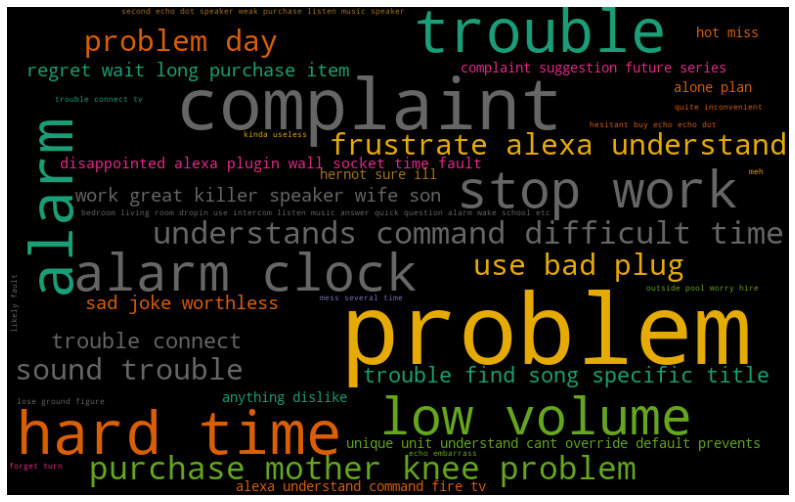

In [21]:
freqDistRDDNeg = negRDDSentiments.flatMap(lambda x : nltk.FreqDist(x).most_common()).map(lambda x: x).reduceByKey(lambda x,y : x+y).sortBy(lambda x: x[1], ascending = False)

df_fDistNeg = freqDistRDDNeg.toDF() #converting RDD to spark dataframe
df_fDistNeg.createOrReplaceTempView("myTableNeg") 
dfNeg = spark.sql("SELECT _1 AS Keywords, _2 as Frequency from myTableNeg limit 40") #renaming columns 
pandDNeg = dfNeg.toPandas() #converting spark dataframes to pandas dataframes

wordcloudConvertDFNeg = pandDNeg.set_index('Keywords').T.to_dict('records')
wordcloudNeg = WordCloud(width=800, height=500, random_state=21, max_font_size=100, relative_scaling=0.5, colormap='Dark2').generate_from_frequencies(dict(*wordcloudConvertDFNeg))
plt.figure(figsize=(14, 10))    
plt.imshow(wordcloudNeg, interpolation="bilinear")
plt.axis('off')
plt.show()

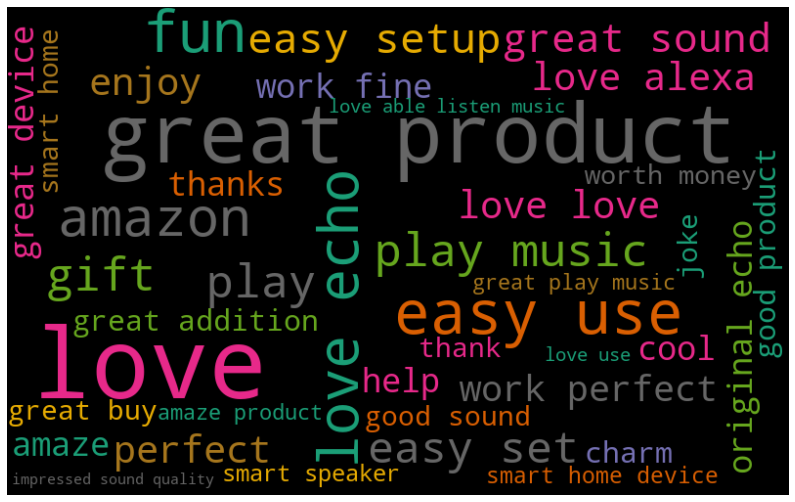

In [22]:
freqDistRDDPos = posRDDSentiments.flatMap(lambda x : nltk.FreqDist(x).most_common()).map(lambda x: x).reduceByKey(lambda x,y : x+y).sortBy(lambda x: x[1], ascending = False)

df_fDistPos = freqDistRDDPos.toDF() #converting RDD to spark dataframe
df_fDistPos.createOrReplaceTempView("myTablePos") 
dfPos = spark.sql("SELECT _1 AS Keywords, _2 as Frequency from myTablePos limit 40") #renaming columns 
pandDPos = dfPos.toPandas() #converting spark dataframes to pandas dataframes

wordcloudConvertDFPos = pandDPos.set_index('Keywords').T.to_dict('records')
wordcloudPos = WordCloud(width=800, height=500, random_state=21, max_font_size=100, relative_scaling=0.5, colormap='Dark2').generate_from_frequencies(dict(*wordcloudConvertDFPos))
plt.figure(figsize=(14, 10))    
plt.imshow(wordcloudPos, interpolation="bilinear")
plt.axis('off')
plt.show()